In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import glob

In [2]:
path = os.getcwd()
file = []
for filename in os.listdir(path):
    if "20_" in filename:
        file.append(filename)

In [3]:
bill_number = []
bill_head = []
full_text = ["" for _ in range(1000)]
count = 0
for files in file:
    with open(files) as f:
        for line in f:
            line = line.strip()
            if line.startswith('Bill_Number'):
                bill_number.append(line[13:])
            if line.startswith('Bill_Title'):
                bill_head.append(line[12:])
            if line.startswith("Fulltext:"):
                for line in f:
                    line = line.strip()
                    if line.startswith("________________________________________________________"):
                        count = count+1
                        break
                    full_text[count] = full_text[count] + line + " "
    f.close()


In [4]:
df = pd.DataFrame(list(zip(bill_number,full_text,bill_head)), columns =['Bill Number', 'Text', 'Bill Title']) 

In [5]:
df['Text1'] = df.Text

In [6]:
df.Text1 = df.Text1.str.replace('[^a-zA-Z ]', ' ')

In [7]:
df.Text1 = df.Text1.str.lower()

In [8]:
from nltk.corpus import stopwords
from collections import Counter
import nltk
stop = stopwords.words('english')
stop.extend(['introduced','virginia', 'bill', 'session', 'person' , 'house', 'no','author', 'license', 'local','public','article'
            'city','county','agency', 'chapter','act','amend','reenact','code','approved','pursuant','designated','chapter',
            'rule','exercise','criterion','town','subject','prelude','shall','rule','permitted','restricted','regulation',
            'assembly','state'])

In [9]:
df.Text1 = df.Text1.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) and len(word) > 3]))

In [10]:
def removal():
    results = Counter()
    df['Text1'].str.split().apply(results.update)
    a = results.most_common(100)
    stop1 = []
    for key,item in a:
        stop1.append(key)
    return stop1

In [11]:
stop1 = removal()
df.Text1 = df.Text1.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop1) and len(word) > 3]))

In [12]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [13]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [14]:
df.Text1 = df.Text1.apply(stem_sentences)

In [15]:
stop1 = removal()
stop1.extend(['offer', 'januari', 'prefil','enact', 'assembl', 'amend','assembl','pass','servic','program','citi','hous'
              ,'number','oper','facil','properti','contract','titl'])
df.Text1 = df.Text1.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop1) and len(word) > 3]))

In [16]:
tfidf = TfidfVectorizer(
    min_df = 5,
    ngram_range=(1,2),
    max_features = 500
)
tfidf.fit(df.Text1)
text = tfidf.transform(df.Text1)

In [17]:
tfidf.get_feature_names()

['absente',
 'abus',
 'accept',
 'access',
 'account',
 'accus',
 'actual',
 'address',
 'adjud',
 'administ',
 'adult',
 'advertis',
 'affect',
 'agenc',
 'agent',
 'agricultur',
 'alleg',
 'allow',
 'also',
 'altern',
 'anim',
 'annual',
 'anoth',
 'appeal',
 'appear',
 'appoint',
 'appropri',
 'approv',
 'area',
 'arrang',
 'arrest',
 'assault',
 'assign',
 'associ',
 'athlet',
 'attempt',
 'attend',
 'attorney',
 'author',
 'award',
 'bank',
 'base',
 'basi',
 'becom',
 'beer',
 'begin',
 'behalf',
 'behavior',
 'benefit',
 'birth',
 'board',
 'bond',
 'borrow',
 'build',
 'calendar',
 'candid',
 'capac',
 'capit',
 'card',
 'carri',
 'carrier',
 'case',
 'caus',
 'center',
 'central',
 'certain',
 'certifi',
 'chang',
 'check',
 'chief',
 'children',
 'circuit',
 'citizen',
 'civil',
 'claim',
 'class',
 'class misdemeanor',
 'claus',
 'clerk',
 'close',
 'collect',
 'colleg',
 'combin',
 'commerci',
 'commit',
 'common',
 'communic',
 'communiti',
 'compani',
 'compens',
 'compla

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(text)

In [18]:
from sklearn.metrics import silhouette_score

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(text.toarray())
X_reduced.shape

(1000, 299)

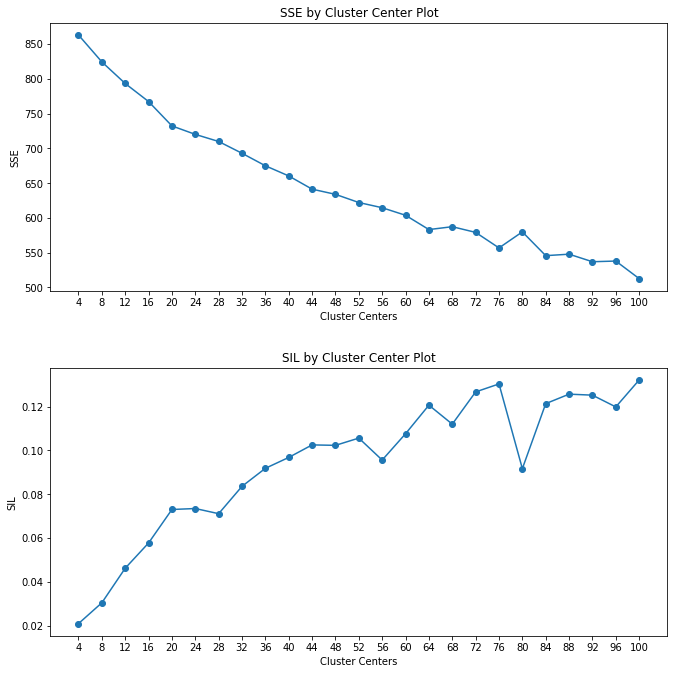

In [25]:
def find_optimal_clusters(data, max_k):
    iters = range(4, max_k+1, 4)
    
    sse = []
    sil = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=20).fit(data).inertia_)
        labels = MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=20).fit_predict(data)
        sil.append(silhouette_score(data, labels, metric = 'euclidean'))
        #print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(2,figsize=(10,10))
    ax[0].plot(iters, sse, marker='o')
    ax[0].set_xlabel('Cluster Centers')
    ax[0].set_xticks(iters)
    ax[0].set_xticklabels(iters)
    ax[0].set_ylabel('SSE')
    ax[0].set_title('SSE by Cluster Center Plot')
    
    ax[1].plot(iters, sil, marker='o')
    ax[1].set_xlabel('Cluster Centers')
    ax[1].set_xticks(iters)
    ax[1].set_xticklabels(iters)
    ax[1].set_ylabel('SIL')
    ax[1].set_title('SIL by Cluster Center Plot')
    f.tight_layout(pad = 3.0)
find_optimal_clusters(X_reduced, 100)

In [26]:
clusters = MiniBatchKMeans(n_clusters=64
                           , batch_size=100, random_state=20).fit_predict(X_reduced)

In [27]:
df['Group'] = clusters
df['Group'].value_counts()

40    143
12     73
15     64
63     34
48     31
     ... 
29      3
60      3
0       3
62      1
36      1
Name: Group, Length: 64, dtype: int64

In [28]:
def get_top_keywords(data, clusters, labels, n_terms):
    df1 = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df1.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 5)


Cluster 0
defend,justic,case,execut,secretari

Cluster 1
issuanc,practic,document,profession,occup

Cluster 2
need,physic,abus,give,consider

Cluster 3
account,capit,taxabl,incom,invest

Cluster 4
capit,person,revenu,bond,sale

Cluster 5
employe,paid,labor,work,wage

Cluster 6
equip,driver,vehicl,devic,highway

Cluster 7
caus,special,injuri,premis,anim

Cluster 8
practic,origin,nation,status,dwell

Cluster 9
sold,sale,impos,consumpt,food

Cluster 10
right,board,human,unlaw,divis

Cluster 11
manag,labor,construct,work,project

Cluster 12
special,land,area,zone,ordin

Cluster 13
cover,carrier,mainten,benefit,coverag

Cluster 14
train,privat,safeti,cours,polic

Cluster 15
transfer,carri,prohibit,guilti,dealer

Cluster 16
financ,primari,elect,contribut,candid

Cluster 17
disabl,standard,certifi,communiti,train

Cluster 18
practic,physician,practition,nurs,patient

Cluster 19
copi,polic,arrest,petition,expung

Cluster 20
regist,envelop,poll,registrar,absente

Cluster 21
term,ordin,appoint,

In [23]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward')
cluster = cluster.fit_predict(text.toarray())

In [24]:
df['Group2'] = cluster
df['Group2'].value_counts()

2     348
0     129
8      67
7      36
9      34
16     29
13     29
6      27
14     26
5      25
21     24
18     23
4      23
3      21
11     20
10     19
22     19
1      18
12     18
15     17
17     12
24     11
23      9
20      9
19      7
Name: Group2, dtype: int64

In [31]:
A = ['' for _ in range(64)]
for i in range(64):
    A[i] = df.loc[df['Group'] == i][['Bill Number','Bill Title','Group']]

In [32]:
for i in range(64):
    A[i].to_csv('output1.csv',index = False,mode='a')